
# Confounded vs deconfounded model comparison

Train multiple classifiers on a confounded dataset and several pre-generated deconfounded datasets (e.g., backdoor, frontdoor, truncated factorisation). Compare their predictive metrics on a shared observational hold-out and on each deconfounded hold-out.



**Workflow**
1. Load confounded CSV and multiple deconfounded CSVs (already generated; no bootstrap here).
2. Align feature columns common to all datasets and split each into train/test.
3. Fit a set of common models on each training set.
4. Evaluate on the same confounded hold-out to see how deconfounding affects generalization to observational data.
5. Also evaluate on each deconfounded hold-out for interventional-like performance.

> Set DECONFOUNDED_DATASETS below to your deconfounded files (same schema + target).


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone


In [2]:

# === Paths & columns ===
CONFOUNDED_PATH = 'heart_disease_preprocessed.csv'
DECONFOUNDED_DATASETS = [
    {'name': 'Backdoor', 'path': 'heart_disease_preprocessed_backdoor.csv'},
    {'name': 'TruncatedFactorisation', 'path': 'heart_disease_preprocessed_tf.csv'},
]

TARGET = 'heartdiseasepresence'
TEST_SIZE = 0.2
RANDOM_SEED = 42

assert Path(CONFOUNDED_PATH).exists(), f"Confounded file not found: {CONFOUNDED_PATH}"
for ds in DECONFOUNDED_DATASETS:
    assert Path(ds['path']).exists(), f"Deconfounded file not found: {ds['path']}"


In [3]:
#Here I am doing basic checks to ensure that all datasets have the same columns and target distributions
# Load datasets
df_conf = pd.read_csv(CONFOUNDED_PATH)
df_conf.columns = [col.replace('[', '_').replace(']', '').replace('<', 'lt').replace('>', 'gt') for col in df_conf.columns]

deconf_dfs = {}
for ds in DECONFOUNDED_DATASETS:
    tempdf = pd.read_csv(ds['path'])
    tempdf.columns = [col.replace('[', '_').replace(']', '').replace('<', 'lt').replace('>', 'gt') for col in tempdf.columns]
    deconf_dfs[ds['name']] = tempdf

# Align columns across all datasets (intersection to ensure comparability)
"""
common_cols = set(df_conf.columns)
for name, df in deconf_dfs.items():
    common_cols = common_cols.intersection(set(df.columns))
assert TARGET in common_cols, f"Target '{TARGET}' must exist in all datasets"

feature_cols = sorted([c for c in common_cols if c != TARGET])

df_conf = df_conf[feature_cols + [TARGET]]
for name in deconf_dfs:
    deconf_dfs[name] = deconf_dfs[name][feature_cols + [TARGET]]

print('Common features:', len(feature_cols))
print('Confounded shape:', df_conf.shape)
for name, df in deconf_dfs.items():
    print(f"Deconfounded ({name}) shape: {df.shape}")

print('Confounded target balance:', df_conf[TARGET].value_counts())
for name, df in deconf_dfs.items():
    print(f"Deconfounded ({name}) target balance:", df[TARGET].value_counts())
"""
feature_cols = sorted([col.replace('[', '_').replace(']', '').replace('<', 'lt').replace('>', 'gt') for col in df_conf.columns if col != TARGET])
print('Feature columns:', feature_cols)
print('Number of features:', len(feature_cols))
print('Confounded shape:', df_conf.shape)
df_conf.head()

Feature columns: ['age', 'ca', 'chol', 'cp_Asymptomatic', 'cp_AtypicalAngina', 'cp_NonAnginalPain', 'cp_TypicalAngina', 'exang_NoExAngina', 'exang_YesExAngina', 'fbs_gt120', 'fbs_lt=120', 'oldpeak', 'restecg_LVHypertrophy', 'restecg_NormalECG', 'restecg_STTAbnormality', 'sex_Female', 'sex_Male', 'slope_Downsloping', 'slope_Flat', 'slope_Upsloping', 'thal_FixedDefect', 'thal_Normal', 'thal_ReversibleDefect', 'thalach', 'trestbps']
Number of features: 25
Confounded shape: (272, 26)


,age,trestbps,chol,thalach,oldpeak,ca,sex_Female,sex_Male,cp_Asymptomatic,cp_AtypicalAngina,...,restecg_STTAbnormality,exang_NoExAngina,exang_YesExAngina,slope_Downsloping,slope_Flat,slope_Upsloping,thal_FixedDefect,thal_Normal,thal_ReversibleDefect,heartdiseasepresence
0,0.950883,0.743598,-0.289108,0.040935,1.180495,-0.740979,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
1,1.397584,1.593663,0.785340,-1.757678,0.647625,2.527338,0,1,1,0,...,0,0,1,0,1,0,0,1,0,1
2,1.397584,-0.673176,-0.370199,-0.858371,1.347500,1.437899,0,1,1,0,...,0,0,1,0,1,0,0,0,1,1
3,-1.952676,-0.106466,0.055526,1.625427,1.775790,-0.740979,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
4,-1.505975,-0.106466,-0.877014,0.983065,0.569273,-0.740979,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0


In [4]:

# Train/test splits for each dataset
splits = {
    'Confounded': {
        'train': None,
        'test': None,
        'label': 'Confounded (observational)'
    }
}

conf_train, conf_test = train_test_split(
    df_conf, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=df_conf[TARGET]
)
splits['Confounded']['train'] = conf_train
splits['Confounded']['test'] = conf_test

for name, df in deconf_dfs.items():
    train_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=df[TARGET]
    )
    splits[name] = {'train': train_df, 'test': test_df, 'label': f'Deconfounded ({name})'}

for name, split in splits.items():
    print(name, 'train/test sizes:', len(split['train']), len(split['test']))


Confounded train/test sizes: 217 55
Backdoor train/test sizes: 217 55
TruncatedFactorisation train/test sizes: 217 55



### Models and evaluation helpers

Metrics: Accuracy, ROC AUC, PR AUC (average precision), Brier score, and log loss.


In [5]:

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, penalty='l2', C=0.1, solver='liblinear', random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=RANDOM_SEED),
    'SVC': SVC(kernel='linear', C=1.0, gamma='scale', random_state=RANDOM_SEED),
    'MLPClassifier': MLPClassifier(
        activation='relu',
        alpha=0.0001,
        hidden_layer_sizes=(50,),
        learning_rate='constant',
        solver='adam',
        max_iter=500,
        random_state=RANDOM_SEED
    ),
    'XGBoost': XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=300,
        subsample=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_SEED
    )
}

def get_probas(model, X):
    if hasattr(model, 'predict_proba'):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, 'decision_function'):
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))
    raise ValueError('Model does not support probability-like outputs')


In [6]:
def evaluate_model(model, X_train, y_train, X_eval, y_eval):
    from sklearn.base import clone
    m = clone(model)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_eval)
    y_proba = get_probas(m, X_eval)
    metrics = {
        'accuracy': accuracy_score(y_eval, y_pred),
        'roc_auc': roc_auc_score(y_eval, y_proba),
        'pr_auc': average_precision_score(y_eval, y_proba),
        'brier': brier_score_loss(y_eval, y_proba),
        'log_loss': log_loss(y_eval, y_proba),
    }
    return metrics

In [7]:

# Evaluate all train/eval combinations
results = []

# Evaluation sets: always include the confounded test, plus each deconfounded test
eval_sets = [('Confounded', splits['Confounded']['test'])]
for name, split in splits.items():
    if name == 'Confounded':
        continue
    eval_sets.append((name, split['test']))

for model_name, model in models.items():
    for train_name, split in splits.items():
        X_train = split['train'][feature_cols]
        y_train = split['train'][TARGET]

        for eval_name, eval_df in eval_sets:
            X_eval = eval_df[feature_cols]
            y_eval = eval_df[TARGET]
            metrics = evaluate_model(model, X_train, y_train, X_eval, y_eval)
            metrics.update({
                'model': model_name,
                'training_data': splits[train_name]['label'],
                'evaluation': 'Confounded test' if eval_name == 'Confounded' else f'Deconfounded test ({eval_name})'
            })
            results.append(metrics)

results_df = pd.DataFrame(results)
results_df


c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

,accuracy,roc_auc,pr_auc,brier,log_loss,model,training_data,evaluation
0,0.836364,0.916667,0.934854,0.116147,0.365940,LogisticRegression,Confounded (observational),Confounded test
1,0.800000,0.911376,0.926495,0.123979,0.383283,LogisticRegression,Confounded (observational),Deconfounded test (Backdoor)
2,0.909091,0.985450,0.986413,0.066564,0.247730,LogisticRegression,Confounded (observational),Deconfounded test (TruncatedFactorisation)
3,0.872727,0.936508,0.948525,0.105725,0.344813,LogisticRegression,Deconfounded (Backdoor),Confounded test
4,0.800000,0.887566,0.907764,0.133808,0.409073,LogisticRegression,Deconfounded (Backdoor),Deconfounded test (Backdoor)
5,0.909091,0.977513,0.980293,0.076919,0.276604,LogisticRegression,Deconfounded (Backdoor),Deconfounded test (TruncatedFactorisation)
6,0.854545,0.929894,0.942182,0.112741,0.364540,LogisticRegression,Deconfounded (TruncatedFactorisation),Confounded test
7,0.818182,0.892857,0.911488,0.131170,0.404403,LogisticRegression,Deconfounded (TruncatedFactorisation),Deconfounded test (Backdoor)
8,0.927273,0.980159,0.981844,0.078239,0.282436,LogisticRegression,Deconfounded (TruncatedFactorisation),Deconfounded test (TruncatedFactorisation)
9,0.854545,0.911376,0.929262,0.125176,0.392796,RandomForest,Confounded (observational),Confounded test



### Combined, tidy comparison table


In [8]:

def tidy(df):
    cols = ['model', 'training_data', 'evaluation', 'accuracy', 'roc_auc', 'pr_auc', 'brier', 'log_loss']
    return df[cols].sort_values(['evaluation', 'model', 'training_data']).reset_index(drop=True)

tidy(results_df)


,model,training_data,evaluation,accuracy,roc_auc,pr_auc,brier,log_loss
0,LogisticRegression,Confounded (observational),Confounded test,0.836364,0.916667,0.934854,0.116147,0.365940
1,LogisticRegression,Deconfounded (Backdoor),Confounded test,0.872727,0.936508,0.948525,0.105725,0.344813
2,LogisticRegression,Deconfounded (TruncatedFactorisation),Confounded test,0.854545,0.929894,0.942182,0.112741,0.364540
3,MLPClassifier,Confounded (observational),Confounded test,0.800000,0.884921,0.912785,0.136108,0.445374
4,MLPClassifier,Deconfounded (Backdoor),Confounded test,0.927273,0.957672,0.967534,0.067715,0.236840
5,MLPClassifier,Deconfounded (TruncatedFactorisation),Confounded test,0.909091,0.969577,0.977891,0.070943,0.244065
6,RandomForest,Confounded (observational),Confounded test,0.854545,0.911376,0.929262,0.125176,0.392796
7,RandomForest,Deconfounded (Backdoor),Confounded test,0.927273,0.978836,0.981684,0.068395,0.244784
8,RandomForest,Deconfounded (TruncatedFactorisation),Confounded test,0.945455,0.988095,0.988824,0.064766,0.238103
9,SVC,Confounded (observational),Confounded test,0.800000,0.919312,0.934636,0.115592,0.356573



### Visualize observational (confounded) test accuracy


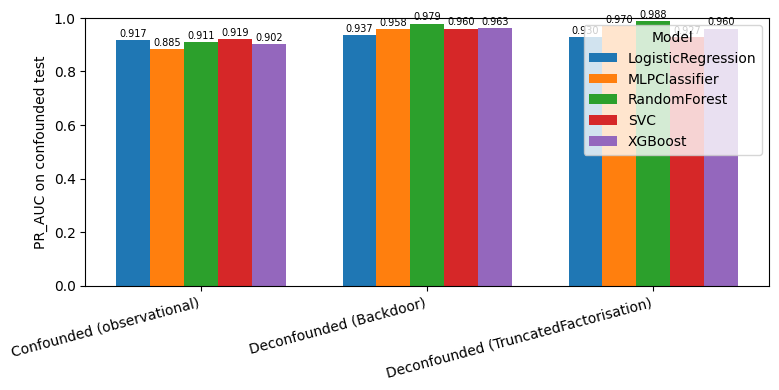

In [ ]:
#can look at 'accuracy', 'roc_auc', 'pr_auc', 'brier', 'log_loss'
import matplotlib.pyplot as plt

plot_df = results_df[results_df['evaluation'] == 'Confounded test'].copy()
fig, ax = plt.subplots(figsize=(8, 4))

train_labels = plot_df['training_data'].unique()
train_labels_sorted = sorted(train_labels)
x_pos = np.arange(len(train_labels_sorted))

width = 0.15
for idx, model_name in enumerate(sorted(plot_df['model'].unique())):
    subset = plot_df[plot_df['model'] == model_name].set_index('training_data').loc[train_labels_sorted]
    bars = ax.bar(x_pos + idx * width, subset['accuracy'], width=width, label=model_name)
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{bar.get_height():.3f}",
                ha='center', va='bottom', fontsize=7)

ax.set_xticks(x_pos + width * (len(plot_df['model'].unique()) - 1) / 2)
ax.set_xticklabels(train_labels_sorted, rotation=15, ha='right')
ax.set_ylabel('PR_AUC on confounded test')
ax.set_ylim(0, 1)
ax.legend(title='Model')
plt.tight_layout()
plt.show()
